In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import math
from scipy.stats import norm

In [2]:
bond_pmts = pd.read_pickle('../../data/mbs_data_pickled/bond_pmts.pkl')
mortgage_losses = pd.read_pickle('../../data/mbs_data_pickled/realized_losses.pkl')
remit_trust_with_swap = pd.read_pickle('../../data/mbs_data_pickled/remit_trust_with_swap.pkl')

In [3]:
# This function adds a Totals row to any permutation of the Bond Payments data
def create_total_row(df):
    columns_to_sum = [df.columns.to_list()[1]]
    remaining_cols = df.columns.to_list()[3:-1]
    columns_to_sum.extend(remaining_cols)
    # Iterate over the months, then for each column, tack on its sum for just that particular month
    for month in np.unique(bond_pmts.index.get_level_values(0).values):
        for col in columns_to_sum:
            # If we're working with the full (original) dataset, we need to remove the non-core securities, like the CE and P tranches
            if 'I-CE' in df.index.get_level_values(1).values:
                bond_pmts.loc[(month,'TOTAL'),col] = bond_pmts.xs(month,level=0).drop(labels=['I-CE','I-P','I-R-1','I-R-2','I-R-3','I-RX',                'II-CE','II-P','II-R-1','II-RX'])[col].sum()
            else:
                df.loc[(month,'TOTAL'),col] = df.xs(month,level=0)[col].sum()
    return df

In [4]:
# Create separate dataframes holding just the senior securities and just the mezzanine securities
# This works by building up boolean arrays describing whether each row corresponds to a senior or mezzanine security (or neither),
# then slicing the rows of bond_pmts based on that
# After that, we create TOTAL rows for each of the two dataframes
senior_slice = [False for row in range(len(bond_pmts))]
mezz_slice = [False for row in range(len(bond_pmts))]
for i in range(len(bond_pmts.index.get_level_values(1).values)):
    security_name = bond_pmts.index.get_level_values(1).values[i]
    if 'A' in security_name and 'TOTAL' not in security_name:
        senior_slice[i] = True
    else:
        senior_slice[i] = False
    if 'M' in security_name:
        mezz_slice[i] = True
    else:
        mezz_slice[i] = False

senior_only = bond_pmts.loc[senior_slice]
senior_only = create_total_row(senior_only)
senior_only = senior_only.sort_index(level=0)
mezz_only = bond_pmts.loc[mezz_slice]
mezz_only = create_total_row(mezz_only)
mezz_only = mezz_only.sort_index(level=0)

# Also add a TOTAL row for bond_pmts itself
bond_pmts = create_total_row(bond_pmts)
bond_pmts = bond_pmts.sort_index(level=0)

<ipython-input-3-80074ce3b494>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[(month,'TOTAL'),col] = df.xs(month,level=0)[col].sum()


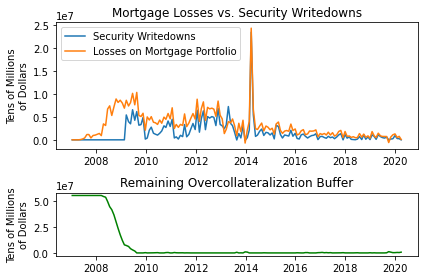

In [5]:
# Create a graph comparing total mortgage realized losses to total security writedowns
graph1_fig, graph1_ax = plt.subplots(2,1,figsize=(6,4),gridspec_kw={'height_ratios':[2,1]})
graph1_ax[0].plot(bond_pmts.xs('TOTAL',level=1)['Principal Adjustment or Loss'],label='Security Writedowns')
graph1_ax[0].plot(mortgage_losses.xs('Total',level=1),label='Losses on Mortgage Portfolio')
graph1_ax[0].legend()
graph1_ax[0].set_ylabel('Tens of Millions\nof Dollars')
graph1_ax[0].set_title('Mortgage Losses vs. Security Writedowns')

# Add in a side-by-side graph of the I-CE tranche to illustrate how credit enhancement is reduced by mortgage losses
total_CE = bond_pmts.xs('I-CE',level=1)['Ending Certificate Balance'] + bond_pmts.xs('II-CE',level=1)['Ending Certificate Balance'] - bond_pmts.xs('TOTAL',level=1)['Ending Certificate Balance']
graph1_ax[1].plot(total_CE, color='green', label = 'Remaining Credit Enhancement Buffer')
graph1_ax[1].set_ylabel('Tens of Millions\nof Dollars')
graph1_ax[1].set_title('Remaining Overcollateralization Buffer')

graph1_fig.tight_layout()
graph1_fig.savefig('../../figures/timeseries_losses_vs_writedowns.png',dpi=200,bbox_inches='tight')

In [6]:
# Import the full Hist Payoff Loss Summary from 2007 to May 2013 (with the summary rows I added on 8/28/2020)
payoff_loss_old_format = pd.read_pickle('../../data/mbs_data_pickled/hist_PL_with_totals.pkl')

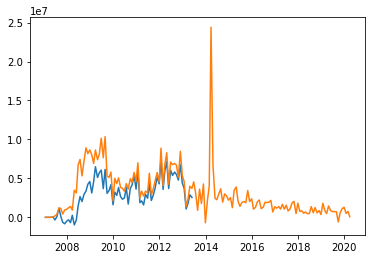

In [7]:
# Going in another direction, we plot realized losses minus liquidation proceeds (blue) and compare that to the straight-up mortgage principal losses 
# figure (orange)
plt.plot(payoff_loss_old_format.xs('Total (All Loans)',level=1)['Realized Losses (Amount)'] - payoff_loss_old_format.xs('Total (All Loans)',level=1)['Liquidation Proceeds'])
plt.plot(mortgage_losses.xs('Total',level=1))

Text(0.5, 1.0, 'Mortgage Pool Size Minus Outstanding\nSecurity Balances [Equals CE Buffer Amount]')

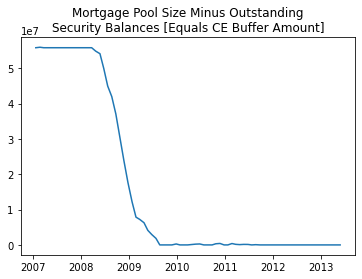

In [8]:
# This graph demonstrates that after the CE buffer is reduced to zero, the mortgage pool shrinks by the same amount as the sum of
# security balances each month -- this one-to-one relationship shows that almost zero credit enhancement remains, as we'd expect
plt.plot(payoff_loss_old_format.xs('Total (All Loans)', level=1)['Ending Pool (Balance)'] - bond_pmts.xs('TOTAL',level=1)['Ending Certificate Balance'])
plt.title('Mortgage Pool Size Minus Outstanding\nSecurity Balances [Equals CE Buffer Amount]')

<ipython-input-9-ab5f5ee369a5>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  LminusW.show()


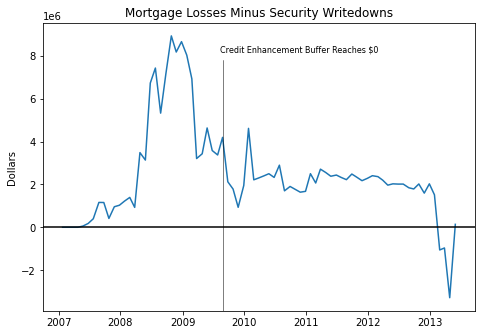

In [9]:
# When we consider just REALIZED LOSSES vs. security principal writedowns, we notice a large disparity after the CE tranche goes to zero,
# which means that the realized loss figure on its own isn't telling the whole story
LminusW = plt.figure()
LminusW_axes = LminusW.add_axes([0,0,1,1])
LminusW_axes.plot(payoff_loss_old_format.xs('Total (All Loans)',level=1)['Realized Losses (Amount)'] - bond_pmts.xs('TOTAL',level=1)['Principal Adjustment or Loss'])
LminusW_axes.axvline(pd.Timestamp('2009-08-25'),color='black',lw=0.5,ymax=0.87)
LminusW_axes.axhline(0,color='black',lw=1.5)
LminusW_axes.text(0.41, 0.9, 'Credit Enhancement Buffer Reaches $0',transform=LminusW_axes.transAxes,fontsize=8)
LminusW_axes.set_title('Mortgage Losses Minus Security Writedowns')
LminusW_axes.set_ylabel('Dollars')
LminusW.show()

Thoughts: <br>
In January 2019 (as an example), the total security balance is roughly equal (within $200) to the total mortgage pool balance, so why don't each of the components that determine principal shrinkage add up? <br>

On the mortgages, there's &dollar;147,152.64 of principal remittance, and &dollar;1,803,099.63 of net realized losses, as well as &dollar;735,959.64 of interest payments remitted to the trust <br>

On the securities, there are &dollar;678,241.37 of principal payments, and &dollar;1,098,961.28 of realized losses, and &dollar;2,876.35 of realized losses recovered, and &dollar;211,774.27 of interest payments

With the securities, we find that Ending Balance = Beginning Balance - Principal Paid - Applied Realized Loss Amount + Applied Realized Loss Amount Recovered

Why do mortgage principal losses not equal security principal writedowns? I think it might be because of extra interest payments sitting around

At EOM Jan 2019, the mortgage principal balance and outstanding securities balance only differ by the $200 sum of the I-P and II-P securities

THE BIG QUESTION RIGHT NOW: explain why even after the CE tranche is emptied out, realized losses on the securities are generally smaller than realized losses on the mortgages

My theory: the excess spread is used to make principal payments after the required coupon on the securities is fulfilled

Data I have: total interest payment on the securities, mortgage realized losses, security writedowns, interest and principal remittance to the trust each month

What I want to do: find out if the excess spread (which I believe is used to pay off principal) accounts for a sizable percentage of the discrepancy between mortgage losses and security writedowns

THOUGHT: Here's why cutting interest rates can help create additional CE for a MBS: when the Fed cuts rates, the WAC of all the securities in the MBS falls, and so do ARM mortgage rates, BUT, fixed mortgage rates stay the same, and the worst mortgages have already dropped out of the deal, and perhaps the swap is still helping out?

ANALYSIS FROM ME: "Every dollar of excess spread that can be used to pay principal to security holders is a dollar of pool losses that will not be felt by the security holders. So, even though pool principal and security principal decline by roughly the same amount each month, the securities have a higher ratio of payments to writedowns than the mortgages do."

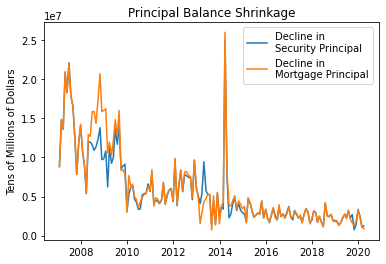

In [10]:
# This graph now shows that the mortgage pool principal balance changes by roughly the same amount as the securities principal balance each month (which is the assumption underlying my idea below about ratio of payments to writedowns being higher for securities than for mortgages, which demonstrates credit enhancement through excess spread)
securities_totals = bond_pmts.xs('TOTAL',level=1)
plt.plot(securities_totals['Principal Payment'] + securities_totals['Principal Adjustment or Loss'], label = "Decline in\nSecurity Principal")
plt.plot(mortgage_losses.xs('Total',level=1)['Realized Losses'] + remit_trust_with_swap.xs('Total',level=1)['Remittance Principal'], label = 'Decline in\nMortgage Principal')
plt.legend(bbox_to_anchor=(0.58,0.9,0.1,0.1))
plt.title('Principal Balance Shrinkage')
plt.ylabel('Tens of Millions of Dollars')
plt.show()

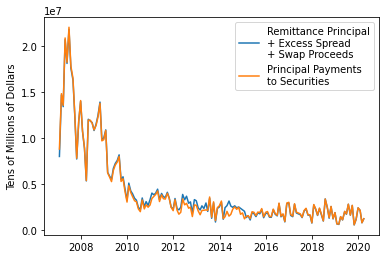

In [11]:
# Let's graph security principal payments against (remitted principal + excess spread) to find out how much of the gap is closed by the excess spread amount
remittance_principal = remit_trust_with_swap.xs('Total',level=1)['Remittance Principal']
remittance_interest = remit_trust_with_swap.xs('Total',level=1)['Remittance Interest']
# Excess spread is the remaining interest in the deal AFTER paying the required interest to all senior and mezzanine securities, as well as the CE securities (if they have any principal balance left) and the P securities
# I have to remember that the CE and P tranches are legitimate (if non-marketed) securities on their own -- as long as each one of them still has a principal balance, it's entitled to interest, which you have to take into account when calculating final excess spread
excess_spread = remittance_interest - bond_pmts.xs('TOTAL',level=1)['Interest Payment'] - bond_pmts.xs('I-CE',level=1)['Interest Payment'] - bond_pmts.xs('II-CE',level=1)['Interest Payment'] - bond_pmts.xs('I-P',level=1)['Interest Payment'] - bond_pmts.xs('II-P',level=1)['Interest Payment']
# Fill in the N/A rows of the swap data (for the years after the swap agreement has ended) with 0
remit_with_full_swap_data = remit_trust_with_swap.fillna(value=0)

net_swap_to_trust = remit_with_full_swap_data.xs('Total',level=1)['Swap Due to Administrator'] - remit_with_full_swap_data.xs('Total',level=1)['Swap Due to Provider']

plt.plot(remittance_principal + excess_spread + net_swap_to_trust,label='Remittance Principal\n+ Excess Spread\n+ Swap Proceeds')
plt.plot(bond_pmts.xs('TOTAL',level=1)['Principal Payment'],label='Principal Payments\nto Securities')
plt.legend()
plt.ylabel('Tens of Millions of Dollars')
plt.savefig('../../figures/timeseries_security_principal_pmts_composition.png',dpi=200,bbox_inches='tight')

# This graph shows that I now have a good understanding of where the principal payments in this deal arise from -- they are the combination of principal remitted from the mortgage borrowers, excess spread, and funds from the swap agreement

In [12]:
# Checking the total disparity: $15 million out of a >$1B deal isn't bad, this tells us that we have a relatively good match
bond_pmts.xs('TOTAL',level=1)['Principal Payment'].sum() - remit_with_full_swap_data.xs('Total',level=1)['Remittance Principal'].sum() - excess_spread.sum() - net_swap_to_trust.sum()

-15446948.798526786

In [13]:
# Total excess spread from the entire period that I have data for
excess_spread.sum()

249631808.798327

Text(0.5, 1.0, 'CE Balance vs. Cumulative Security Writedowns')

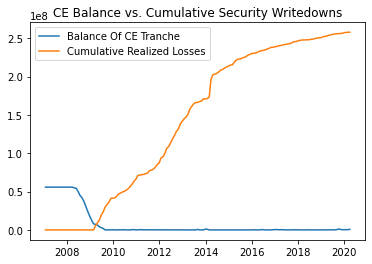

In [14]:
# This graph confirms that realized losses on securities start to show when the CE tranche approaches zero, although those don't happen exactly at the same time
# My thought is that maybe one Group's CE tranche is zeroed out before the other one is, so losses start showing up on the total even though there's some CE left in the entire deal
plt.plot(bond_pmts.xs('I-CE',level=1)['Ending Certificate Balance'] + bond_pmts.xs('II-CE',level=1)['Ending Certificate Balance'] - bond_pmts.xs('TOTAL',level=1)['Ending Certificate Balance'],label='Balance Of CE Tranche')
plt.plot(bond_pmts.xs('TOTAL',level=1)['Principal Adjustment or Loss'].cumsum(),label='Cumulative Realized Losses')
plt.legend()
plt.title('CE Balance vs. Cumulative Security Writedowns')

In [15]:
losses_without_spread_and_swap = mortgage_losses.xs('Total',level=1)['Realized Losses']
losses_with_spread_and_swap = losses_without_spread_and_swap - excess_spread - net_swap_to_trust
losses_saved_ratio = losses_with_spread_and_swap.sum() / losses_without_spread_and_swap.sum()
losses_saved_ratio # THIS IS OVER 50%, WHICH IS WAY HIGHER THAN I EXPECTED!
# We've learned something new here -- the presence of fixed-rate loans could be thought of as a form of credit enhancement in the event of bad performance by the ARM loans, since excess spread (along with the swap) protected investors from over 50% of realized losses
# The other possibility is that coupons on the securities declined more rapidly than coupons on the mortgages
# We'll test this by looking at the ROUGH average coupon rate for the securities and the ROUGH average coupon rate for the mortgages
# Issue with this method: how do we account for the interest on the CE security?? It doesn't have a set coupon rate
# REMEMBER: for the mortgages, we're looking at the interest remitted to the trust, not the actual interest paid by borrowers -- the difference would probably be servicing fees?
# rough_avg_coupon_securities = bond_pmts.xs('TOTAL',level=1)['Interest Payment'] / bond_pmts.xs('TOTAL',level=1)['Beginning Certificate Balance']
# rough_avg_coupon_mortgages = remit_trust_with_swap.xs('Total',level=1)['Remittance Interest'] = mortgage_losses.xs('Total',level=1)['Ending Balance (Amount)']

0.587538467919877

Possible next step: to be able to calculate the ROUGH average coupon on the mortgages, I need to extract (by modifying the extract_remittances_to_trust code) the ending mortgage pool size, not just the number of loans like I have in the delinquency stats

ALSO, look into the "Advances" section in Pool Non-Pool Funds, to see if that could make up the last of the difference between mortgage principal remitted and security principal paid

# Tracing losses on Fixed and ARM loans

As I said back in July, I want to check on what percentage of the mortgage losses are attributable to fixed vs. ARM loans. I'll first do just a straight-up "Fixed vs. ARM losses" comparison, then I'll compute it on a percentage basis (total losses as a percentage of initial balance), to see if ARM loans disproportionately did worse than fixed-rate loans. Now that I think about it, I'll do this for every subgroup, so we can find out which loans performed the worst.

I think I want to output some sort of table that's just describing loss rate for each subgroup, initial principal balance as % of total, and losses as % of total.

In [16]:
# Compute the initial sizes of each loan type, as well as Fixed, ARM, Group I, Group II, and Total
# Trying this both for January 2007 (when the totals don't quite add up) and March 2007 (the first month when they do)
pool_size_after_jan07 = pd.DataFrame(payoff_loss_old_format.xs('2007-01-25',level=0)['Ending Pool (Balance)'])
pool_size_after_jan07.rename(columns={'Ending Pool (Balance)':'Ending Principal Balance (January 2007)'},inplace=True)
pool_size_after_mar07 = pd.DataFrame(payoff_loss_old_format.xs('2007-03-26',level=0)['Ending Pool (Balance)'])
pool_size_after_mar07.rename(columns={'Ending Pool (Balance)':'Ending Principal Balance (March 2007)'},inplace=True)

# Also make dataframes with the number of loans of each type, for possible hypothesis-testing purposes
num_of_loans_after_jan07 = pd.DataFrame(payoff_loss_old_format.xs('2007-01-25',level=0)['Ending Pool (Count)'])
num_of_loans_after_jan07.rename(columns={'Ending Pool (Count)':'Ending Number of Loans (January 2007)'},inplace=True)
num_of_loans_after_mar07 = pd.DataFrame(payoff_loss_old_format.xs('2007-03-26',level=0)['Ending Pool (Count)'])
num_of_loans_after_mar07.rename(columns={'Ending Pool (Count)':'Ending Number of Loans (March 2007)'},inplace=True)


# Compute the total realized losses from January 2007 to May 2013 for each loan type
loan_types = payoff_loss_old_format.xs('2007-01-25',level=0).index.get_level_values(0)
cumulative_mortgage_losses = pd.DataFrame(data=None,index=loan_types,columns=['Realized Losses from January 2007 to May 2013'])
for loan_type in loan_types.to_list():
    cumulative_mortgage_losses.loc[loan_type] = payoff_loss_old_format.xs(loan_type,level=1)['Realized Losses (Amount)'].sum()

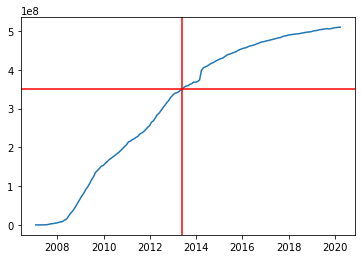

In [17]:
# Through some matplotlib magic, this graph confirms that the cumulative_mortgage_losses data has the correct numbers, since the
# cumulative losses in May 2013 from the original mortgage_losses_dataset match up with the cumulative losses from my new dataframe
# (the two red lines, one for May 2013 and one for cumulative losses calculated in the new DF, intersect exactly on the series)
plt.plot(mortgage_losses.xs('Total',level=1).cumsum())
plt.axhline(cumulative_mortgage_losses.loc['Total (All Loans)']['Realized Losses from January 2007 to May 2013'],color='red')
plt.axvline(pd.Timestamp('2013-05-28'),color='red')
plt.show()

There's a problem with the January and February 2007 data: the 'Total (All Loans)' principal balance is NOT equal to the sum of the principal balances for all the other loan types, which is really weird. This error is resolved in March, though.

The question at hand is: for calculating loss percentages, do I use the March 2007 principal balances (which are slightly after the "start" of the deal), since they have everything matching up right, or should I use the January 2007 principal balances in order to get as close as possible to a loss % of original principal?

I'll do it both ways and see if there's a big difference

In [18]:
# Calculate the fraction of principal that ended up being written off in each loan group
mortgage_loss_rates_jan07_base = pd.DataFrame(cumulative_mortgage_losses['Realized Losses from January 2007 to May 2013'] / \
pool_size_after_jan07['Ending Principal Balance (January 2007)'], columns=['Loss Rate (baseline = January 2007)'])
mortgage_loss_rates_mar07_base = pd.DataFrame(cumulative_mortgage_losses['Realized Losses from January 2007 to May 2013'] / \
pool_size_after_mar07['Ending Principal Balance (March 2007)'], columns=['Loss Rate (baseline = March 2007)'])

# Calculate each loan type's share of the initial principal balance
principals_as_pct_of_jan07_total = pool_size_after_jan07 / pool_size_after_jan07.loc['Total (All Loans)']['Ending Principal Balance (January 2007)']
principals_as_pct_of_jan07_total.rename(columns={'Ending Principal Balance (January 2007)':'January 2007 Principal Balance as Fraction of January 2007 Total'},inplace=True)
principals_as_pct_of_mar07_total = pool_size_after_mar07 / pool_size_after_mar07.loc['Total (All Loans)']['Ending Principal Balance (March 2007)']
principals_as_pct_of_mar07_total.rename(columns={'Ending Principal Balance (March 2007)':'March 2007 Principal Balance as Fraction of March 2007 Total'},inplace=True)

# Calculate each loan type's share of the total mortgage losses from January 2007 to May 2013
losses_as_pct_of_all_losses = pd.DataFrame(cumulative_mortgage_losses['Realized Losses from January 2007 to May 2013'] / \
cumulative_mortgage_losses.loc['Total (All Loans)']['Realized Losses from January 2007 to May 2013'])
losses_as_pct_of_all_losses.rename(columns={'Realized Losses from January 2007 to May 2013':'Realized Losses as Fraction of January 2007-May 2013 Total'},inplace=True)

In [19]:
# Prepare the final table, which I plan on including in my report
LOAN_TYPE_COMPARISON = pd.concat([num_of_loans_after_mar07,pool_size_after_mar07,mortgage_loss_rates_mar07_base,principals_as_pct_of_mar07_total,losses_as_pct_of_all_losses],axis=1)

In [20]:
LOAN_TYPE_COMPARISON.iloc[0:2]

,Ending Number of Loans (March 2007),Ending Principal Balance (March 2007),Loss Rate (baseline = March 2007),March 2007 Principal Balance as Fraction of March 2007 Total,Realized Losses as Fraction of January 2007-May 2013 Total
Group,,,,,
ARM,3405.0,8.471955e+08,0.319716,0.75985,0.772642
Fixed,1668.0,2.677550e+08,0.297675,0.24015,0.227358


In [21]:
# Variation of the LOAN_TYPE_COMPARISON table to send to RK with my outline -- also include laon counts and balances in May 2013
num_of_loans_after_may13 = pd.DataFrame(payoff_loss_old_format.xs('2013-05-28',level=0)['Ending Pool (Count)'])
num_of_loans_after_may13.rename(columns={'Ending Pool (Count)':'Ending Number of Loans (May 2013)'},inplace=True)

pool_size_after_may13 = pd.DataFrame(payoff_loss_old_format.xs('2013-05-28',level=0)['Ending Pool (Balance)'])
pool_size_after_may13.rename(columns={'Ending Pool (Balance)':'Ending Principal Balance (May 2013)'},inplace=True)

LOAN_TYPE_COMPARISON2 = pd.concat([num_of_loans_after_mar07,pool_size_after_mar07,num_of_loans_after_may13,pool_size_after_may13,mortgage_loss_rates_mar07_base,principals_as_pct_of_mar07_total,losses_as_pct_of_all_losses],axis=1)
LOAN_TYPE_COMPARISON2.iloc[0:2]

,Ending Number of Loans (March 2007),Ending Principal Balance (March 2007),Ending Number of Loans (May 2013),Ending Principal Balance (May 2013),Loss Rate (baseline = March 2007),March 2007 Principal Balance as Fraction of March 2007 Total,Realized Losses as Fraction of January 2007-May 2013 Total
Group,,,,,,,
ARM,3405.0,8.471955e+08,1342.0,3.028954e+08,0.319716,0.75985,0.772642
Fixed,1668.0,2.677550e+08,714.0,1.311720e+08,0.297675,0.24015,0.227358


My last idea about this table would be to do a simple z-test to figure out whether the difference in loss rates between Fixed and ARM loans is statistically significant, but I'm somewhat concerned that within each bucket, the data aren't independent (i.e. two borrowers living in the same state will both have their ability to repay influenced by that particular state's economy)

Reservations:
- What exactly is the population we're talking about? All mortgages in the USA would be way too broad.
- How can we know that the individual mortgages are independent? Isn't there likely correlation between them based on state/metro area?

In [22]:
# Try doing the t-test myself, since I'd need the loss rate for every individual mortgage if I wanted to plug my data into statsmodels or another library with built-in statistical tests
p1_hat = LOAN_TYPE_COMPARISON.loc['ARM']['Loss Rate (baseline = March 2007)']
p2_hat = LOAN_TYPE_COMPARISON.loc['Fixed']['Loss Rate (baseline = March 2007)']

n_1 = LOAN_TYPE_COMPARISON.loc['ARM']['Ending Number of Loans (March 2007)']
n_2 = LOAN_TYPE_COMPARISON.loc['Fixed']['Ending Number of Loans (March 2007)']

p_pooled = (p1_hat * n_1 + p2_hat * n_2) / (n_1 + n_2)

z_stat = (p1_hat - p2_hat) / math.sqrt(p_pooled*(1-p_pooled)*(1/n_1+1/n_2))
p_val = 1 - norm.cdf(z_stat)
print(p_val)
print('So, the difference between loss rates from January 2007 to May 2013 for fixed and adjustable-rate mortgages in this deal was\n'+\
    'not quite statistically significant at p = 0.05')

0.055788081877546025
So, the difference between loss rates from January 2007 to May 2013 for fixed and adjustable-rate mortgages in this deal was
not quite statistically significant at p = 0.05


In [23]:
# We should also do a quick comparison (2007-May 2013) with the total loss (writedown) rates on the SECURITIES, to give singular proof of how investors' capital is insulated from mortgage losses
total_security_writedowns = pd.DataFrame(bond_pmts.xs('TOTAL',level=1)['Principal Adjustment or Loss'])
query1 = total_security_writedowns.index >= pd.Timestamp('2007-01-01')
intermediate_df = total_security_writedowns[query1]
query2 = intermediate_df.index <= pd.Timestamp('2013-05-31')
returned_df = intermediate_df[query2]
cumulative_security_writedowns = returned_df['Principal Adjustment or Loss'].sum()
cumulative_security_writedowns
securities_balance_after_mar07 = bond_pmts.xs('TOTAL',level=1).loc['2007-03-26']['Ending Certificate Balance']
securities_loss_rate = cumulative_security_writedowns / securities_balance_after_mar07

In [24]:
mortgage_losses_felt_by_securities = cumulative_security_writedowns / payoff_loss_old_format.xs('Total (All Loans)',level=1)['Realized Losses (Amount)'].sum()

In [25]:
# BY THE NUMBERS
print("SUMMARY: PERFORMANCE OF BSABS 2006-HE10 BY THE NUMBERS")
print('From January 2007 to May 2013:')
print('The loss rate on all mortgages was ' + str(round(LOAN_TYPE_COMPARISON.loc['Total (All Loans)']['Loss Rate (baseline = March 2007)']*100,2)) +"%",end='\n\n')
print('The loss rate on all securities was ' + str(round(securities_loss_rate*100,2)) + "%",end='\n\n')
print('The percentage of mortgage write-offs felt by security holders was ' + str(round(mortgage_losses_felt_by_securities*100,2))+"%",end='\n\n')
print('(The reason the quotient of loss rates is slightly higher than 46.07% is the overcollateralization at the start of the deal, \nwhich makes the initial security balance smaller than the initial mortgage principal balance)',end='\n\n')
print('The combination of excess spread and proceeds from the swap agreements had the effect of reducing the dollar value of \nsecurity writeoffs by ' + str(round(losses_saved_ratio*100,2)) + "% compared to what the security holders would have felt if protected only by the CE balance",end='\n\n')
print('Adjustable-rate loans made up ' + str(round(LOAN_TYPE_COMPARISON.loc['ARM']['March 2007 Principal Balance as Fraction of March 2007 Total']*100,2)) + '% of the mortgage pool at the deal\'s start, and ' + str(round(LOAN_TYPE_COMPARISON.loc['ARM']['Realized Losses as Fraction of January 2007-May 2013 Total']*100,2)) + "% of mortgage writeoffs, but\nthe difference in loss rates between fixed-rate and adjustable-rate loans was not statistically significant at p = 0.05")

SUMMARY: PERFORMANCE OF BSABS 2006-HE10 BY THE NUMBERS
From January 2007 to May 2013:
The loss rate on all mortgages was 31.44%

The loss rate on all securities was 15.25%

The percentage of mortgage write-offs felt by security holders was 46.07%

(The reason the quotient of loss rates is slightly higher than 46.07% is the overcollateralization at the start of the deal, 
which makes the initial security balance smaller than the initial mortgage principal balance)

The combination of excess spread and proceeds from the swap agreements had the effect of reducing the dollar value of 
security writeoffs by 58.75% compared to what the security holders would have felt if protected only by the CE balance

Adjustable-rate loans made up 75.99% of the mortgage pool at the deal's start, and 77.26% of mortgage writeoffs, but
the difference in loss rates between fixed-rate and adjustable-rate loans was not statistically significant at p = 0.05


In [26]:
bond_pmts.xs('TOTAL',level=1)['Principal Adjustment or Loss'].sum() / mortgage_losses.xs('Total',level=1)['Realized Losses'].sum()
print('If we go ALL THE WAY OUT TO MARCH 2020, the percentage of mortgage losses felt by security holders ticks up to about 50.58%')
print('I think this accounts for many realized losses being booked somewhat after the bankruptcy/foreclosure peak in the 2011-2012 period --\nonce lots of losses started showing up at once, a relatively unchanging excess spread rate wasn\'t enough to cancel out quite as many losses as before')

If we go ALL THE WAY OUT TO MARCH 2020, the percentage of mortgage losses felt by security holders ticks up to about 50.58%
I think this accounts for many realized losses being booked somewhat after the bankruptcy/foreclosure peak in the 2011-2012 period --
once lots of losses started showing up at once, a relatively unchanging excess spread rate wasn't enough to cancel out quite as many losses as before


## Final conclusions from Losses vs. Writedowns analysis
-  The initial credit enhancement buffer was quickly brought down to zero by poor performance of the mortgage pool, but even after initial overcollateralization ran out, the deal's excess spread continued to serve as a form of credit enhancement (likely due to the Fed's slashing rates and the presence of fixed-rate mortgages in this deal)
- Just like the prospectus specified, principal remittances were 

In [27]:
# Let's do a bit of "growth accounting" here by decomposing principal payments into their three components from the graph above
principal_to_securities = remittance_principal + excess_spread + net_swap_to_trust
remit_P_contrib_to_securities = remittance_principal.sum() / principal_to_securities.sum()
XS_contrib_to_securities = excess_spread.sum() / principal_to_securities.sum()
swap_contrib_to_securities = net_swap_to_trust.sum() / principal_to_securities.sum()
print(remit_P_contrib_to_securities)
print(XS_contrib_to_securities)
print(swap_contrib_to_securities)
print()
principal_to_securities_after_swap = remittance_principal + excess_spread
remit_P_contrib_after_swap = remittance_principal.sum() / principal_to_securities_after_swap.sum()
XS_contrib_after_swap = excess_spread.sum() / principal_to_securities_after_swap.sum()
print(remit_P_contrib_after_swap)
print(XS_contrib_after_swap)

0.6864646915253438
0.37208532873022976
-0.05855002025557345

0.6484952797597657
0.3515047202402343


In [28]:
print((remit_trust_with_swap.xs('Total',level=1)['Swap Due to Administrator'] - remit_trust_with_swap.xs('Total',level=1)['Swap Due to Provider']).sum())
print('Final net swap proceeds for trustee')

-39281171.0998
Final net swap proceeds for trustee
